In [3]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
from PIL import Image

# Convert RGB to Grayscale manually while keeping the original RGB
class ColorizationDataset(Dataset):
    def __init__(self, train=True):
        self.data = torchvision.datasets.CIFAR10(root='./data', train=train, download=True)
        self.transform_input = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()
        ])
        self.transform_target = transforms.ToTensor()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, _ = self.data[idx]
        input_img = self.transform_input(img)
        target_img = self.transform_target(img)
        return input_img, target_img

train_dataset = ColorizationDataset(train=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


Files already downloaded and verified


In [4]:
import torch.nn as nn
import torch.nn.functional as F

class ColorizationCNN(nn.Module):
    def __init__(self):
        super(ColorizationCNN, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),  # Input: (B, 1, 32, 32)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # (B, 128, 16, 16)
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),  # (B, 64, 32, 32)
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid()  # Output in [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ColorizationCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for gray, color in train_loader:
        gray, color = gray.to(device), color.to(device)
        optimizer.zero_grad()
        output = model(gray)
        loss = criterion(output, color)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/10], Loss: 0.0082
Epoch [2/10], Loss: 0.0064
Epoch [3/10], Loss: 0.0061
Epoch [4/10], Loss: 0.0059
Epoch [5/10], Loss: 0.0058
Epoch [6/10], Loss: 0.0057
Epoch [7/10], Loss: 0.0057
Epoch [8/10], Loss: 0.0057
Epoch [9/10], Loss: 0.0056
Epoch [10/10], Loss: 0.0056


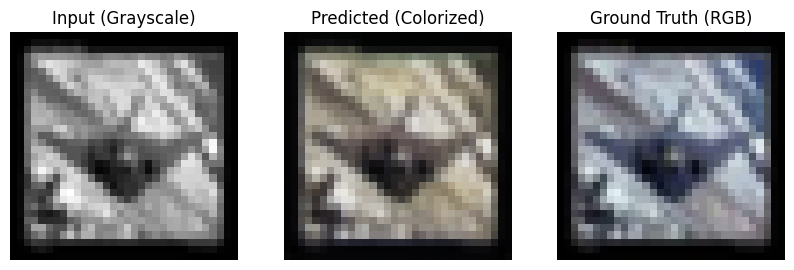

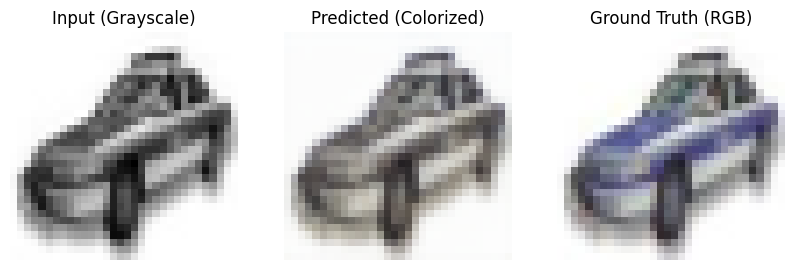

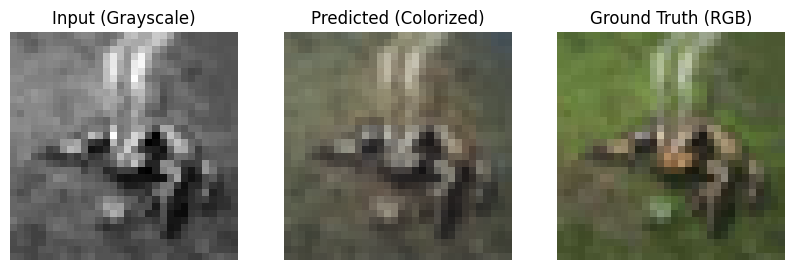

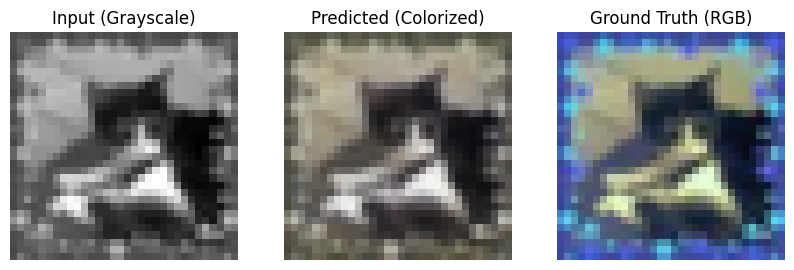

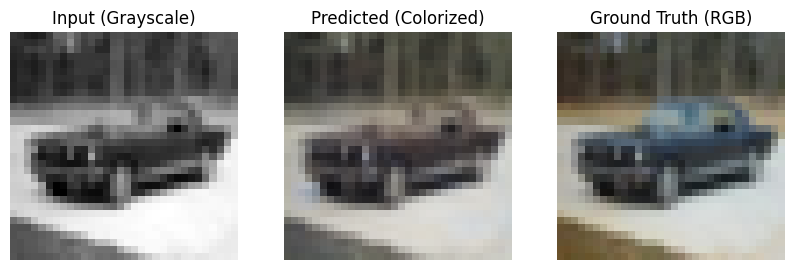

In [6]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    gray, color = next(iter(train_loader))
    gray, color = gray.to(device), color.to(device)
    output = model(gray)

# Show 5 samples
for i in range(5):
    fig, axs = plt.subplots(1, 3, figsize=(10, 3))
    
    axs[0].imshow(gray[i].squeeze().cpu(), cmap='gray')
    axs[0].set_title("Input (Grayscale)")
    
    axs[1].imshow(output[i].permute(1, 2, 0).cpu())
    axs[1].set_title("Predicted (Colorized)")
    
    axs[2].imshow(color[i].permute(1, 2, 0).cpu())
    axs[2].set_title("Ground Truth (RGB)")

    for ax in axs: ax.axis('off')
    plt.show()


In [10]:
torch.save(model.state_dict(), "color_model.pth")


In [11]:
torch.save(model, 'color_model_full.pth')  # save entire model
